# Self-Driving Car Engineer Nanodegree


## Project: ** Advanced Lane Lines Detection on Road images/videos** 
***


## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import io
import pathlib
import os
import math

## Implementation of advanced lane finding Pipeline

### Calibrate camera

In [2]:
# Define camera calibration function with parameters
# function allows for checking of calibration results both as plots and file outputs

def calibrate_camera(rows = 6, columns = 9, inputfolder = 'camera_cal', outputfolder = 'output_images', calibration_plots = False):

    ### Setting the folders & parameters for calibration images
    dir_calib_images = inputfolder
    dir_output = outputfolder
    chessboard_columns = columns
    chessboard_rows = rows

    pathlib.Path(dir_output).mkdir(parents=True, exist_ok=True)

    list_calib_images = os.listdir(dir_calib_images)
    
    if (calibration_plots == True):
        print("The following camera calibration images are used (folder '" + dir_calib_images +"':)")
        print(list_calib_images)

    ### Calibrating camera

    # Declare object and image points
    objpoints = [] #3D points in real world space
    imgpoints = [] #2D points in image plane

    # Preparing object points with shape (0,0,0)...(9,5,0)
    objp = np.zeros((chessboard_rows * chessboard_columns,3), np.float32)
    objp[:,:2] = np.mgrid[0:chessboard_columns, 0:chessboard_rows].T.reshape(-1,2)

    ## Loop through all images
    ## Detect chessboard and store objpoints and imgpoints
    for file in list_calib_images:

        # Read in image and grayscale
        img = cv2.imread(dir_calib_images + '/' + file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (chessboard_columns, chessboard_rows), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

        # Draw chessboard corners
        image_chessboard = cv2.drawChessboardCorners(np.copy(gray), (chessboard_columns, chessboard_rows), corners, ret)

    ## Calibrate camera using object and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

    # Output undistorted calibration images to output folder & plot images
    if calibration_plots == True:
        
        for file in list_calib_images:

            # Output images to folder
            img = cv2.imread(dir_calib_images + '/' + file)
            image_undistort = cv2.undistort(img, mtx, dist, None, mtx)

            mpimg.imsave(dir_output + '/undistorted_' + file, image_undistort, format='jpg')


            # Output exemplary plots (grayscale, detected corners and undistorted)
            print('Plotting camera calibration images \n')
            fig, axs = plt.subplots(1,3)
            fig.set_size_inches(25,6)

            fig.add_subplot(1,3,1)
            axs[0].set_title('Greyscale')
            axs[0].axis('off')
            plt.imshow(gray, cmap='gray')

            fig.add_subplot(1,3,2)
            axs[1].set_title('Chessboard corners')
            axs[1].axis('off')
            plt.imshow(image_chessboard, cmap='gray')

            image_undistort = cv2.undistort(img, mtx, dist, None, mtx)

            fig.add_subplot(1,3,3)
            axs[2].set_title('Undistorted (color)')
            axs[2].axis('off')
            plt.imshow(image_undistort)
    
    
    # Return calibration parameters/matrices 
    return mtx, dist

### Undistort image

In [3]:
# Clean undistort function without any outputs

def undistort(img, mtx, dst):
    image_undistort = cv2.undistort(img, mtx, dst, None, mtx)
    return image_undistort

### Create threshold binary image

In [4]:
def binary_threshold(img, x_thresh_min = 40, x_thresh_max = 200, s_thresh_min = 180, s_thresh_max = 255):

    # Parameters

    # x-Axis sobel thresholds
    #x_thresh_min = 40
    #x_thresh_max = 200

    # Color channel thresholds

    #s_thresh_min = 180
    #s_thresh_max = 255

    #h_thresh_min = 15 
    #h_thresh_max = 100

    # l_thresh_min = 100
    # l_thresh_max = 180

    # Loop through all input test images


    # Convert to HLS space and isolate channels
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    s_channel = hls[:,:,2]
    #h_channel = hls[:,:,0]
    #l_channel = hls[:,:,1]

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply x-axis derivative on grayscale image
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    ## Calculate Sobel binary image using thresholds
    sobelx_binary = np.zeros_like(sobelx)
    sobelx_binary[(scaled_sobel >= x_thresh_min) & (scaled_sobel <= x_thresh_max)] = 1

    ## Caclulate color channel binary images using thresholds

    # s-channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # h-channel does not yield useful results
    # h_binary = np.zeros_like(h_channel)
    # h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1

    # l-channel does not yield useful results
    #l_binary = np.zeros_like(s_channel)
    #l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    # Stacking of color channels to show individual lane detection contribution
    #stacked_binary = np.dstack(np.uint8((np.zeros_like(sobelx_binary), sobelx_binary, s_binary)))*255
    stacked_binary = np.dstack(np.uint8((np.zeros_like(s_binary), sobelx_binary, s_binary)))*255

    # Combining binary images
    combined_binary = np.zeros_like(s_channel)
    combined_binary[(s_binary == 1) | (sobelx_binary == 1)] = 1

    return combined_binary, stacked_binary


### Mask region of interest (ROI)

In [5]:
def region_of_interest(img, width_ratio, height_ratio):
    
    # Read image shape and store in imshape
    imshape = img.shape
    
    # Calculate aligned vertices of ROI
    vertices = np.array([[(0,imshape[0]),\
                          (math.floor(imshape[1]*(1-width_ratio)),math.floor(imshape[0]*(1-height_ratio))),\
                          (math.floor(imshape[1]*width_ratio), math.floor(imshape[0]*(1-height_ratio))),\
                          (imshape[1],imshape[0])]],\
                        dtype=np.int32)
    
    # Create empty mask
    mask = np.zeros_like(img)
    
    # Fill mask pixels within vertices
    cv2.fillPoly(mask, vertices, 255)
    
    # Process bitwise AND to mask out ROI
    roi_img = cv2.bitwise_and(img, mask)
    
    return roi_img, vertices
    

### Perform perspective transform

In [6]:
#### Calculate transform matrix ####

def transform_matrix(roi_binary, trans_top_width, trans_bot_width, trans_height, width_rescale):
    
    imshape = img.shape
    
    # Calculate source while assuming trapezoid
    source = np.float32([[imshape[1] * (1-trans_bot_width), imshape[0]],\
                        [imshape[1] * (1-trans_top_width), imshape[0] * (1-trans_height)],\
                        [imshape[1] * trans_top_width, imshape[0] * (1-trans_height)],\
                        [imshape[1]* trans_bot_width, imshape[0]]])
    
    # Assusming bottom width is equal to top width
    destination = np.float32([[imshape[1] * (1-trans_bot_width*width_rescale), imshape[0]],\
                             [imshape[1] * (1-trans_bot_width*width_rescale),0],\
                             [imshape[1] * trans_bot_width*width_rescale, 0],\
                             [imshape[1] * trans_bot_width*width_rescale, imshape[0]]])
    
    # Calculate transform matrix M & inverse transform matrix Minv
    M = cv2.getPerspectiveTransform(source, destination)
    Minv = cv2.getPerspectiveTransform (destination, source)
    
    return M, Minv, source

#### Warp image ####
def warp(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

### Identify lane line pixels and fit polynomials

In [7]:
#### HISTOGRAM ####
def histogram_half(img):
    
    # Identify bottom half of image height
    bottom_img = img[np.uint(img.shape[0]/2):img.shape[0],:]
    
    # Sum up all image pixels along y-axis
    hist = np.sum(bottom_img, axis = 0)
    
    return hist


#### FINDING LANE PIXELS ####
# Takes a binary image and identifies lane line pixels
def find_lane_pixels(img, nwindows = 9, margin = 100, minpix = 50):
    
    # Get histogram for bottom half of image
    hist = histogram_half(img)
    
    # Create output image to visualize result
    out_img = np.dstack((img, img, img))* 255
    
    # Identify peaks of left and right lane in histogram
    midpoint = np.uint(hist.shape[0]//2)
    
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    
    window_height = np.uint(img.shape[0] // nwindows)
    
    # Identify x&y for all nonzero pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set current position to initial position (later update in loop)
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty list for left & right lane pixels
    left_lane_index = []
    right_lane_index = []
    
    # Go through each windows, beginning from bottom of image
    
    for window in range(nwindows):
        
        # Set window frames for both lanes
        ## Set boundary along y-axis (same for both lanes)
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = win_y_low + window_height
        
        ## Set boundary along x-axis (left & right separately)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        
        # Draw  windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2) 
        
        
        # Identify non-zero pixels for left and right within window
        fitting_left_index = ((nonzerox >= win_xleft_low) &
                              (nonzerox <= win_xleft_high) &
                              (nonzeroy >= win_y_low) &
                              (nonzeroy <= win_y_high)).nonzero()[0]
        
        fitting_right_index = ((nonzerox >= win_xright_low) &
                               (nonzerox < win_xright_high) &
                               (nonzeroy >= win_y_low) &
                               (nonzeroy < win_y_high)).nonzero()[0]
        
        # Append indices to lists
        left_lane_index.append(fitting_left_index)
        right_lane_index.append(fitting_right_index)

        # If minimum pixels found, recenter next window to mean value
        if len(fitting_left_index) > minpix:
            leftx_current = np.uint(np.mean(nonzerox[fitting_left_index]))

        if len(fitting_right_index) > minpix:
            rightx_current = np.uint(np.mean(nonzerox[fitting_right_index]))
    
    # Cast lane indices to array format (previously list of lists)
    left_lane_index = np.concatenate(left_lane_index)
    right_lane_index = np.concatenate(right_lane_index)
    
    # Extract left and right lane pixel positions
    # that lay within slided windows from before
    leftx = nonzerox[left_lane_index]
    lefty = nonzeroy[left_lane_index]

    rightx = nonzerox[right_lane_index]
    righty = nonzeroy[right_lane_index]

    return out_img, leftx, lefty, rightx, righty



#### FITTING POLYNOMIAL ####
def fit_polynomial(img, leftx, lefty, rightx, righty):
    
    # Fit 2. order polynomial to identified image points
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Calculate x & y values for plotting
    # Set evenly spaced numbers along image y-axis
    ploty = np.linspace(0,img.shape[0]-1, img.shape[0])
    
    # Try catches errors if left_fit and _right fit are none or invalid
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        left_fit = ploty * 0
        right_fit = ploty * 0
        
    # Visualize results
    output_img = np.copy(img)
    output_img[lefty, leftx] = [0, 0 , 255] # left = blue
    output_img[righty, rightx] = [255, 0, 0] # right = red
    
    # Draw fitted polynomial on image
    pts_left = np.array(list(zip(left_fitx, ploty)), np.int32).reshape((-1,1,2))
    cv2.polylines(output_img, [pts_left], False, (0, 255, 255), 5)
    
    pts_right = np.array(list(zip(right_fitx, ploty)), np.int32).reshape((-1,1,2))
    cv2.polylines(output_img, [pts_right], False, (0, 255, 255), 5)    
    
    return output_img, pts_left, pts_right, left_fit, right_fit, ploty
    
    
    

### Calculate radius of curvature and vehicle offset

In [8]:
#### CALCULATING CURVATURE AND POSITION ####

# Function takes in left and right lane binary points, fitted polynomial from previous step (image space)
# bottom pixel along y-axis, image midpoint and scaling ratios for y and x-axis

def curvature(leftx, lefty, rightx, righty, left_fit_img, right_fit_img, ybottom, midpoint, xm_per_pixel, ym_per_pixel):
    
    # Scaling parameter from pixel to real world
    ybottom_scaled = ybottom * ym_per_pixel
    
    ## Fitting 2nd order polynomial using approximated real world scale ##
    left_fit = np.polyfit(lefty * ym_per_pixel, leftx * xm_per_pixel, 2)
    right_fit = np.polyfit(righty * ym_per_pixel, rightx * xm_per_pixel, 2)
    
    # Calculating radius of curvature using real world scale #
    radius_left = (1 + (2 * left_fit[0] * ybottom_scaled + left_fit[1]) **2) **1.5 / np.absolute(2 * left_fit[0])
    radius_right = (1 + (2 * right_fit[0] * ybottom_scaled + right_fit[1]) **2) **1.5 / np.absolute(2 * right_fit[0])

    ## Calculating offset vs. midpoint of image ##
    # Fitting 2nd order polynomial for image space
    
    leftx_base = left_fit_img[0] * ybottom**2 + left_fit_img[1] * ybottom + left_fit_img[2]
    rightx_base = right_fit_img[0] * ybottom**2 + right_fit_img[1] * ybottom + right_fit_img[2]
    
    # positive offset -> vehicle is too much on the right
    # negative offset -> vehicle is too much on the left
    offset = (midpoint - np.mean([leftx_base, rightx_base])) * xm_per_pixel
    
    return radius_left, radius_right, offset

### Output lane boundaries on original image

In [9]:
# Function outputs lane boundaries and calculated vehicle telemetry
# (curvature + offset) on image

def lane_projection(img, M, Minv, pts_left, pts_right, radius_left, radius_right, offset):
    
    # Creating copy of original road image
    img_lines = np.zeros_like(img)
    
    # Drawing lane lines on warped real image
    cv2.polylines(img_lines, [pts_left], False, (0, 0, 255), 40) # left = blue
    cv2.polylines(img_lines, [pts_right], False, (255, 0, 0), 40) # right = red
    
    # Drawing filled area identified as valid lane
    lane = np.array([pts_left, pts_right[::-1]]).reshape(-1,1,2)
    cv2.fillPoly(img_lines, [lane], color=(0,100,0))
    
    # Warping image back using inverse matrix (already calculated in upstream)
    img_projectedlines = warp(img_lines, Minv)
    
    # Blending original image and lane projections
    output_img = cv2.addWeighted(img, 1.0, img_projectedlines, 1.0, 0)
    
    # Adding telemetry text on image
    mean_radius = np.int32(np.mean([radius_left, radius_right]))
    offset_cm = np.absolute(np.int32(offset * 100))
    
    text_radius = "mean curvature radius: " + str(mean_radius) + "m"
    cv2.putText(output_img, text_radius, (20,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    if offset < 0:
        text_offset = "Offset: " + str(offset_cm) + "cm left of lane midpoint"
    else:
        text_offset = "Offset: " + str(offset_cm) + "cm right of lane midpoint"
    
    cv2.putText(output_img, text_offset, (20,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    
    return output_img
    

---
### Assembling the pipeline

In [10]:
#Pipeline takes in an RGB-image and boolean for (not) plotting results



def lane_detect(img, mtx, dist, plots = False):
    
    #### PARAMETERS ####
    # Thresholding parameters
    x_thresh_min = 20
    x_thresh_max = 200

    s_thresh_min = 150
    s_thresh_max = 255

    # Cropping parameters
    roi_width_ratio = 0.51
    roi_height_ratio = 0.43

    # Transform parameters
    trans_top_width = 0.5325
    trans_bot_width = 0.855
    trans_height = 0.38

    width_rescale = 0.85 # scales width of transform destination points

    # Sliding window parameters
    nwindows = 9
    margin = 100
    minpix = 50

    # Lane curvatute & offset parameters
    xm_per_pixel = 3.7/600 # U.S. interstate highway standard lane width (in meters) is 3.7m
    ym_per_pixel = 3.0/720 * 10 #Estimating one lane line (=3.0m) equals 1/10 of image height 


    #### UNDISTORT IMAGE ####    
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)


    ##### COMPUTE BINARY IMAGE ####
    #Call thresholding function (returns combined binary image + stacked image (G: Sobel x) & (B: s-channel) )
    binary_combined, binary_stacked = binary_threshold(undistorted_img, x_thresh_min, x_thresh_max, s_thresh_min, s_thresh_max)


    #### MASK ROI ####
    roi_binary, vertices = region_of_interest(binary_combined, roi_width_ratio, roi_height_ratio)


    #### PERFORM PERSPECTIVE TRANSFORM ####
    # Obtain transform matrix & inverse transform matrix
    M, Minv, source_points = transform_matrix(roi_binary, trans_top_width, trans_bot_width, trans_height, width_rescale)

    # Warp image
    binary_warped = warp(roi_binary, M)

    
    #### IDENTIFY LANE LINE PIXELS & FIT POLYNOMIALS ###

    # Identifying lane pixels and outputting them as
    # separate points for left & right lane line
    img_lanepixels, leftx, lefty, rightx, righty = find_lane_pixels(binary_warped, nwindows, margin, minpix)

    # Fit polynomial and return annotated image with lane curvature + coefficients
    img_polyfit, pts_left, pts_right, left_fit, right_fit, ploty = fit_polynomial(img_lanepixels, leftx, lefty, rightx, righty)


    #### CALCULATE CURVATURE AND OFFSET ###
    radius_left, radius_right, offset = curvature(leftx, lefty, rightx, righty, left_fit, right_fit, img_lanepixels.shape[0], np.uint(img_lanepixels.shape[1]//2), xm_per_pixel, ym_per_pixel)


    #### PROJECT LANE LINE ON ORIGINAL (UNDIST.) IMAGE ###
    projection_img = lane_projection(undistorted_img, M, Minv, pts_left, pts_right, radius_left, radius_right, offset)


    # Output plots if set to 'True'

    if plots == True:

        # Adding ROI vertices on undist. original image
        img_vertices = np.copy(undistorted_img)
        cv2.polylines(img_vertices, np.int32([vertices]), True, (255,0,0), 3)


        # Adding transform source points on roi_binary image
        roi_binary_source = np.dstack(np.uint8((roi_binary, roi_binary, roi_binary)))*255
        cv2.polylines(roi_binary_source, np.int32([source_points]), True, (0,255,0), 3)


        # Setting subplot frames
        fig, axs = plt.subplots(3, 3)
        fig.set_size_inches(40, 20)

        # Plotting original image with ROI
        fig.add_subplot(3,3,1)
        axs[0,0].set_title('Undist. Original Image + ROI')
        axs[0,0].axis('off')
        plt.imshow(img_vertices)


        # Plotting threshold images
        fig.add_subplot(3,3,2)
        axs[0,1].set_title('Stacked binary thresholds')
        axs[0,1].axis('off')
        plt.imshow(binary_stacked)

        fig.add_subplot(3,3,3)
        axs[0,2].set_title('Combined threshold binary')
        axs[0,1].axis('off')
        plt.imshow(binary_combined, cmap='gray')


        # Plotting ROI binary image
        fig.add_subplot(3,3,4)
        axs[1,0].set_title('ROI binary image + source points')
        axs[1,0].axis('off')
        plt.imshow(roi_binary_source)


        # Plotting warped image
        fig.add_subplot(3,3,5)
        axs[1,1].set_title('Warped ROI binary image')
        axs[1,1].axis('off')
        plt.imshow(img_polyfit)

        #Plotting histogram of warped image
        hist = histogram_half(binary_warped)

        fig.add_subplot(3,3,6)
        axs[1,2].set_title('histogram of warped image')
        axs[1,2].axis('off')
        plt.plot(hist)

        # Plotting warped image
        fig.add_subplot(3,3,7)
        axs[2,0].set_title('Lane lines projection on undist. orig. image')
        axs[2,0].axis('off')
        plt.imshow(projection_img)

        #print("\nLeft lane curve radius in meters")
        #print("%.0f" %(radius_left))

        #print("\nRight lane curve radius in meters")
        #print("%.0f" %(radius_right))

        #print("\nVehicle offset vs. lane midpoint in meters\n(neg -> too much on the left | pos -> too much on the right)")
        #print("%.1f" %(offset))
    
    return projection_img


---
## Calling the pipeline with test images

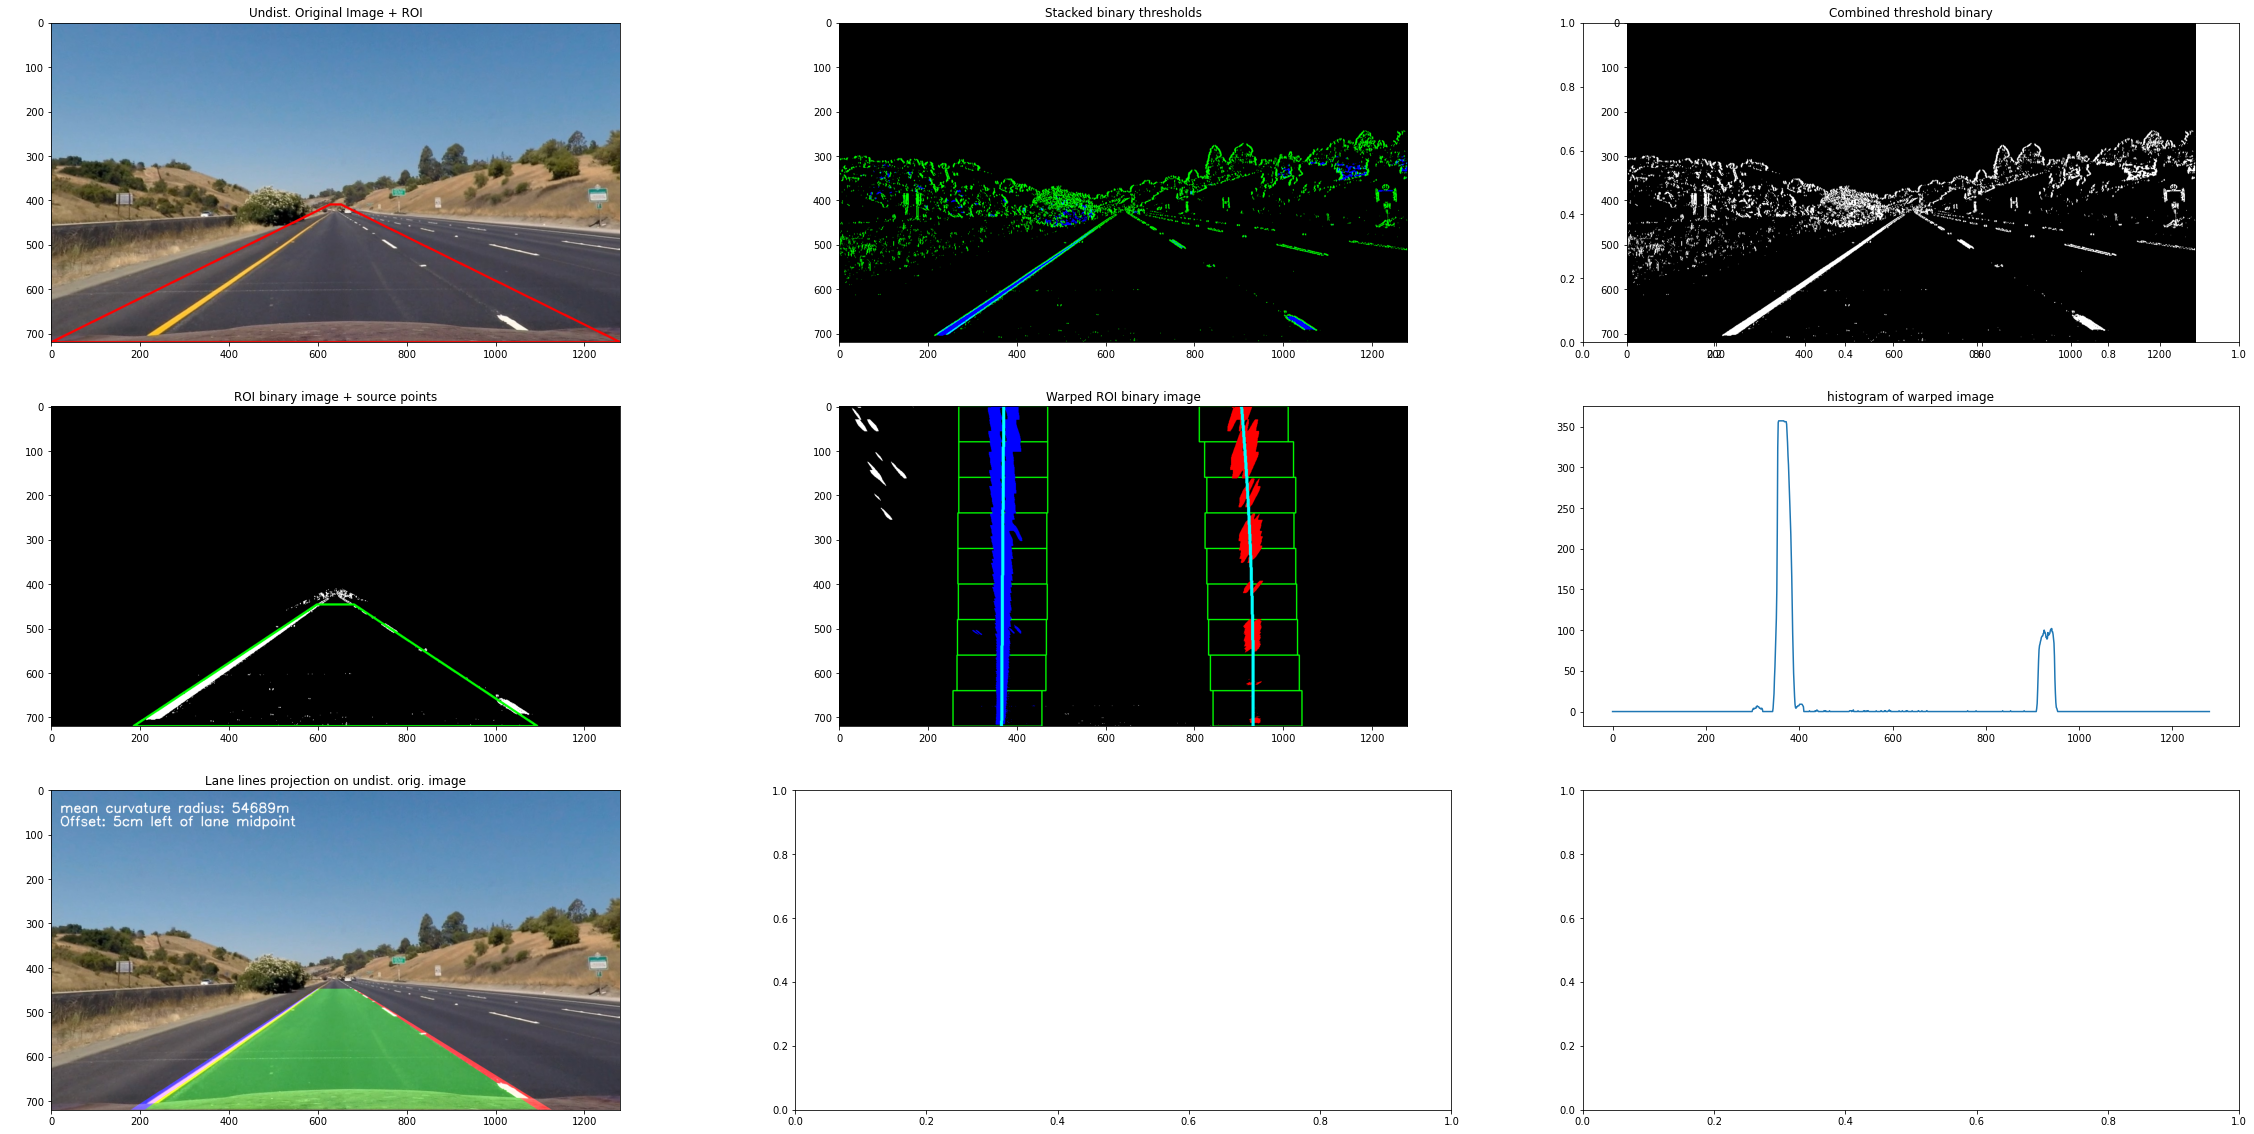

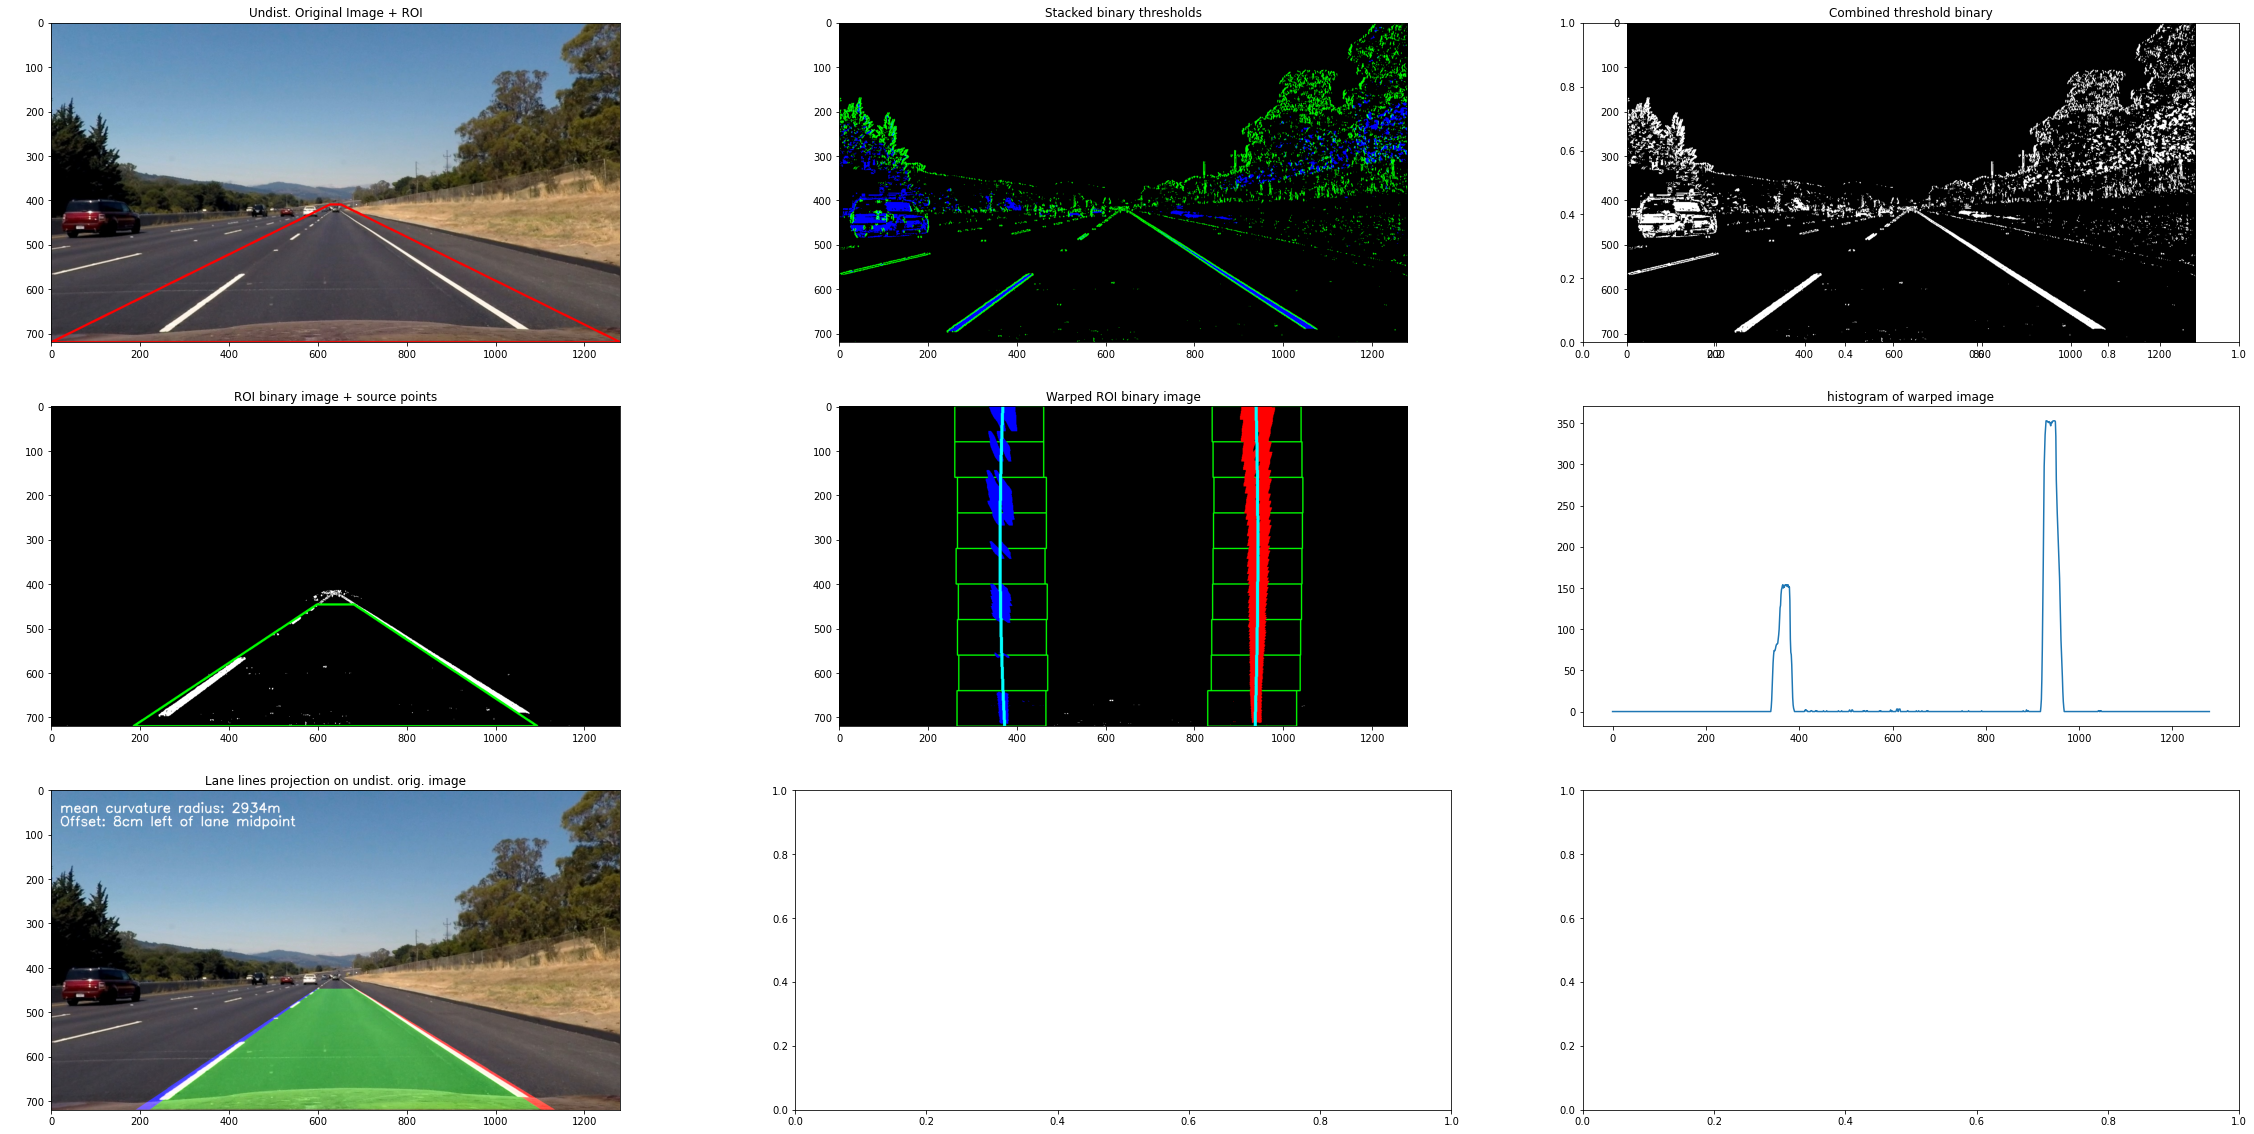

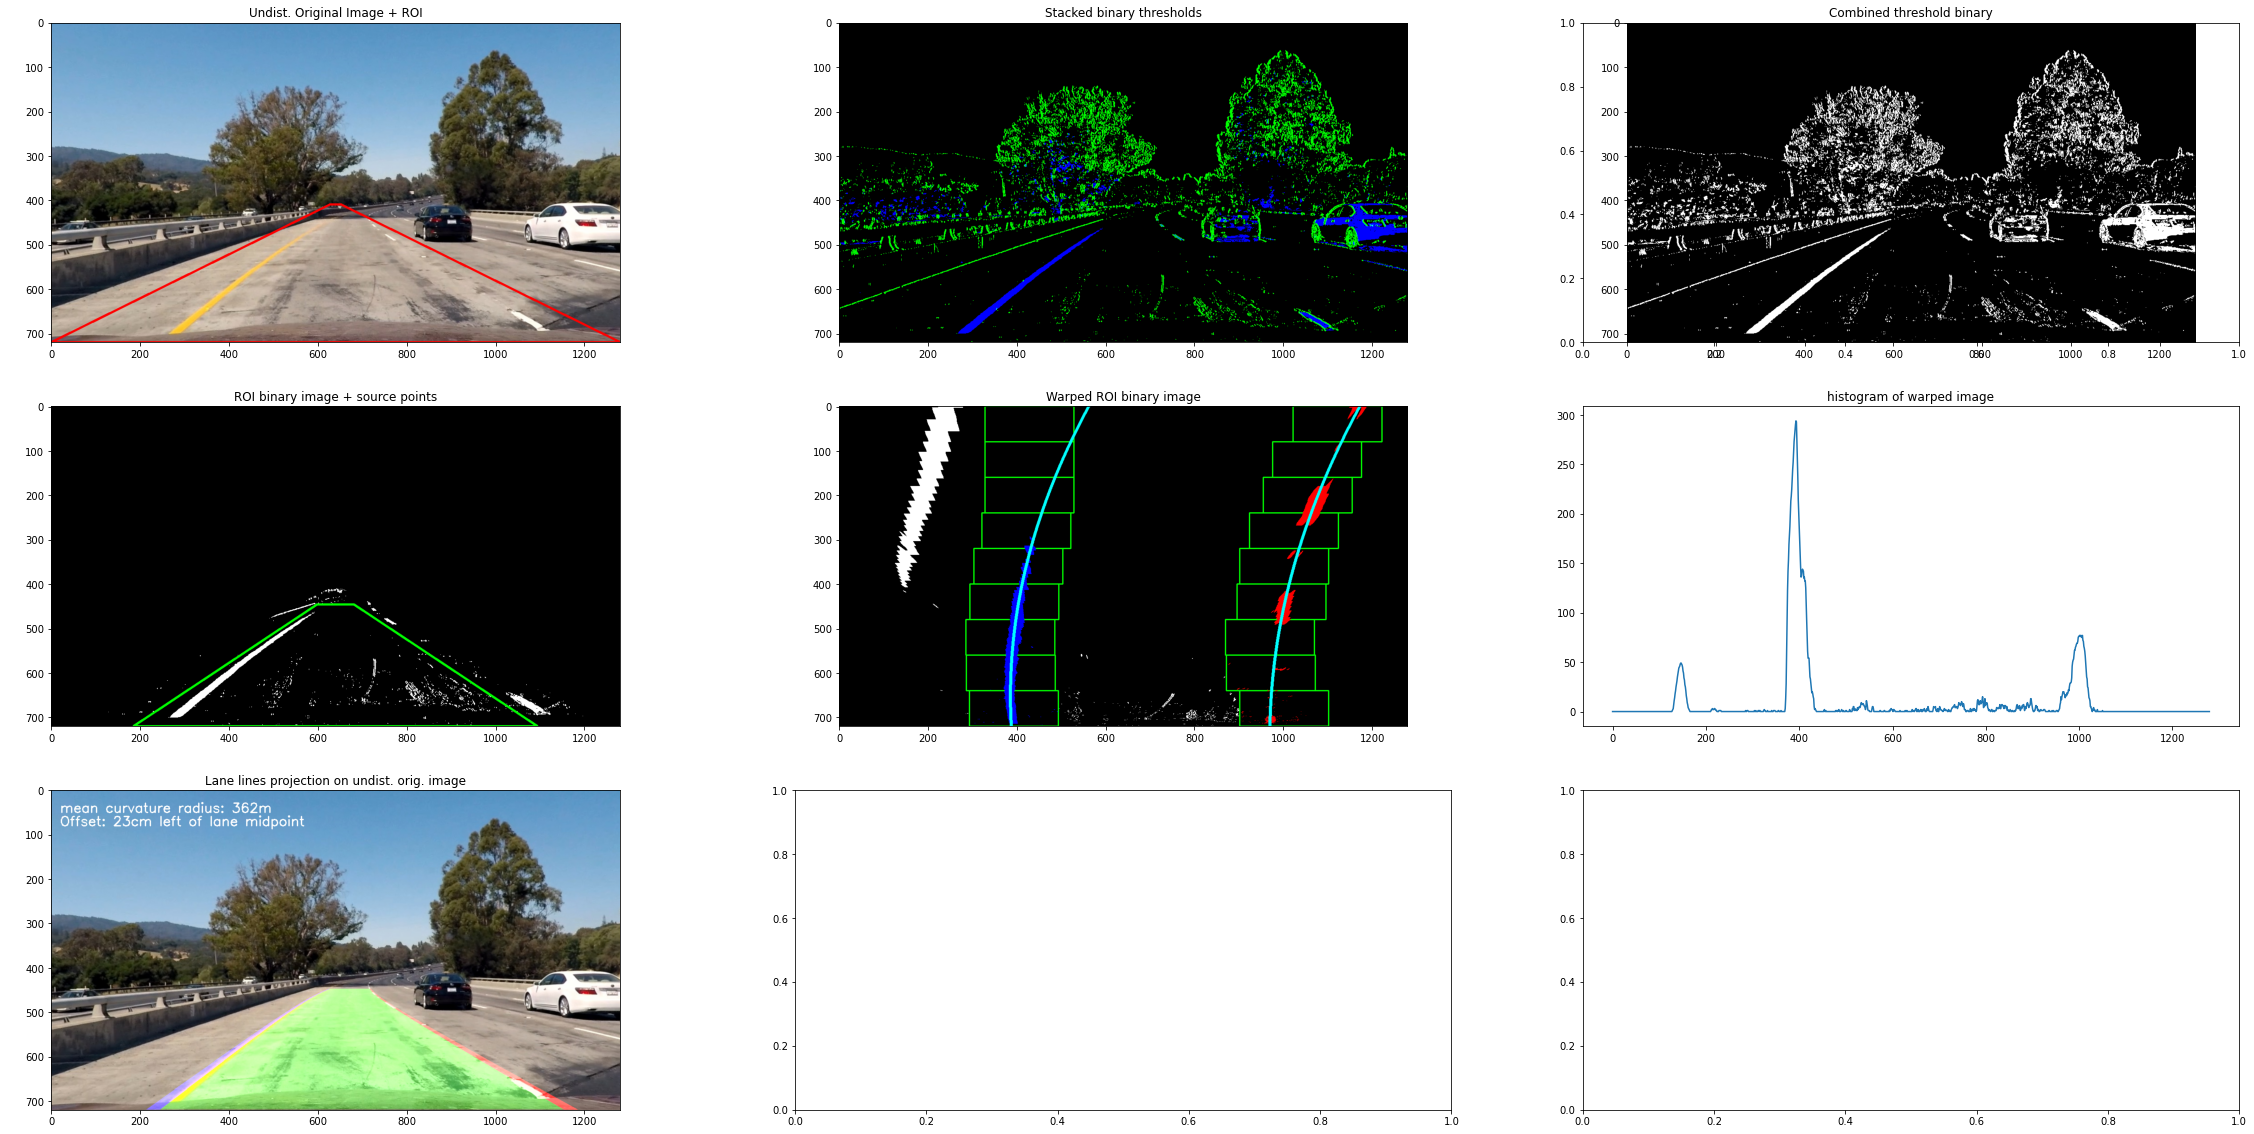

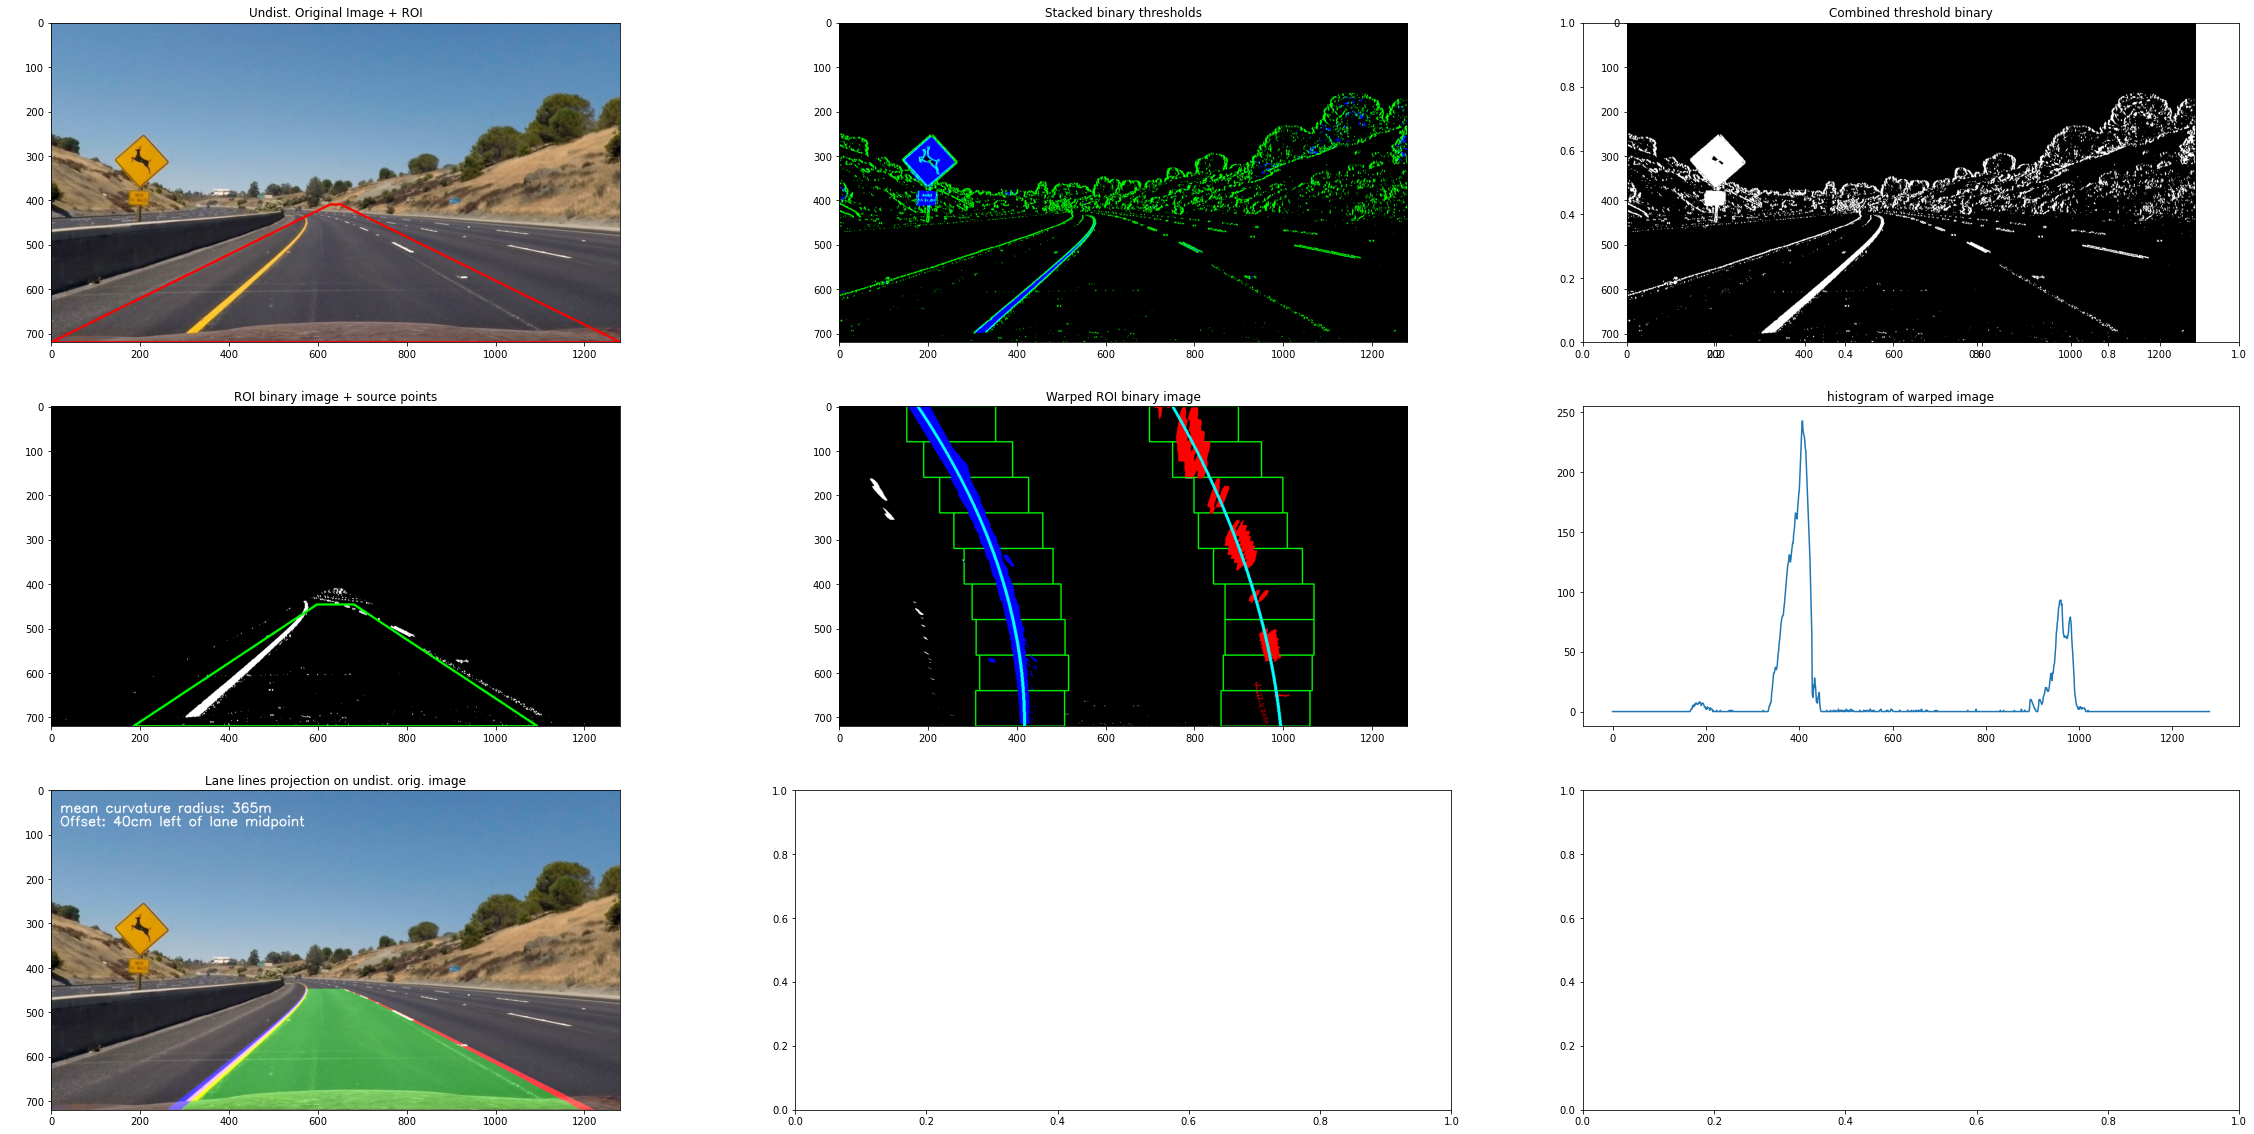

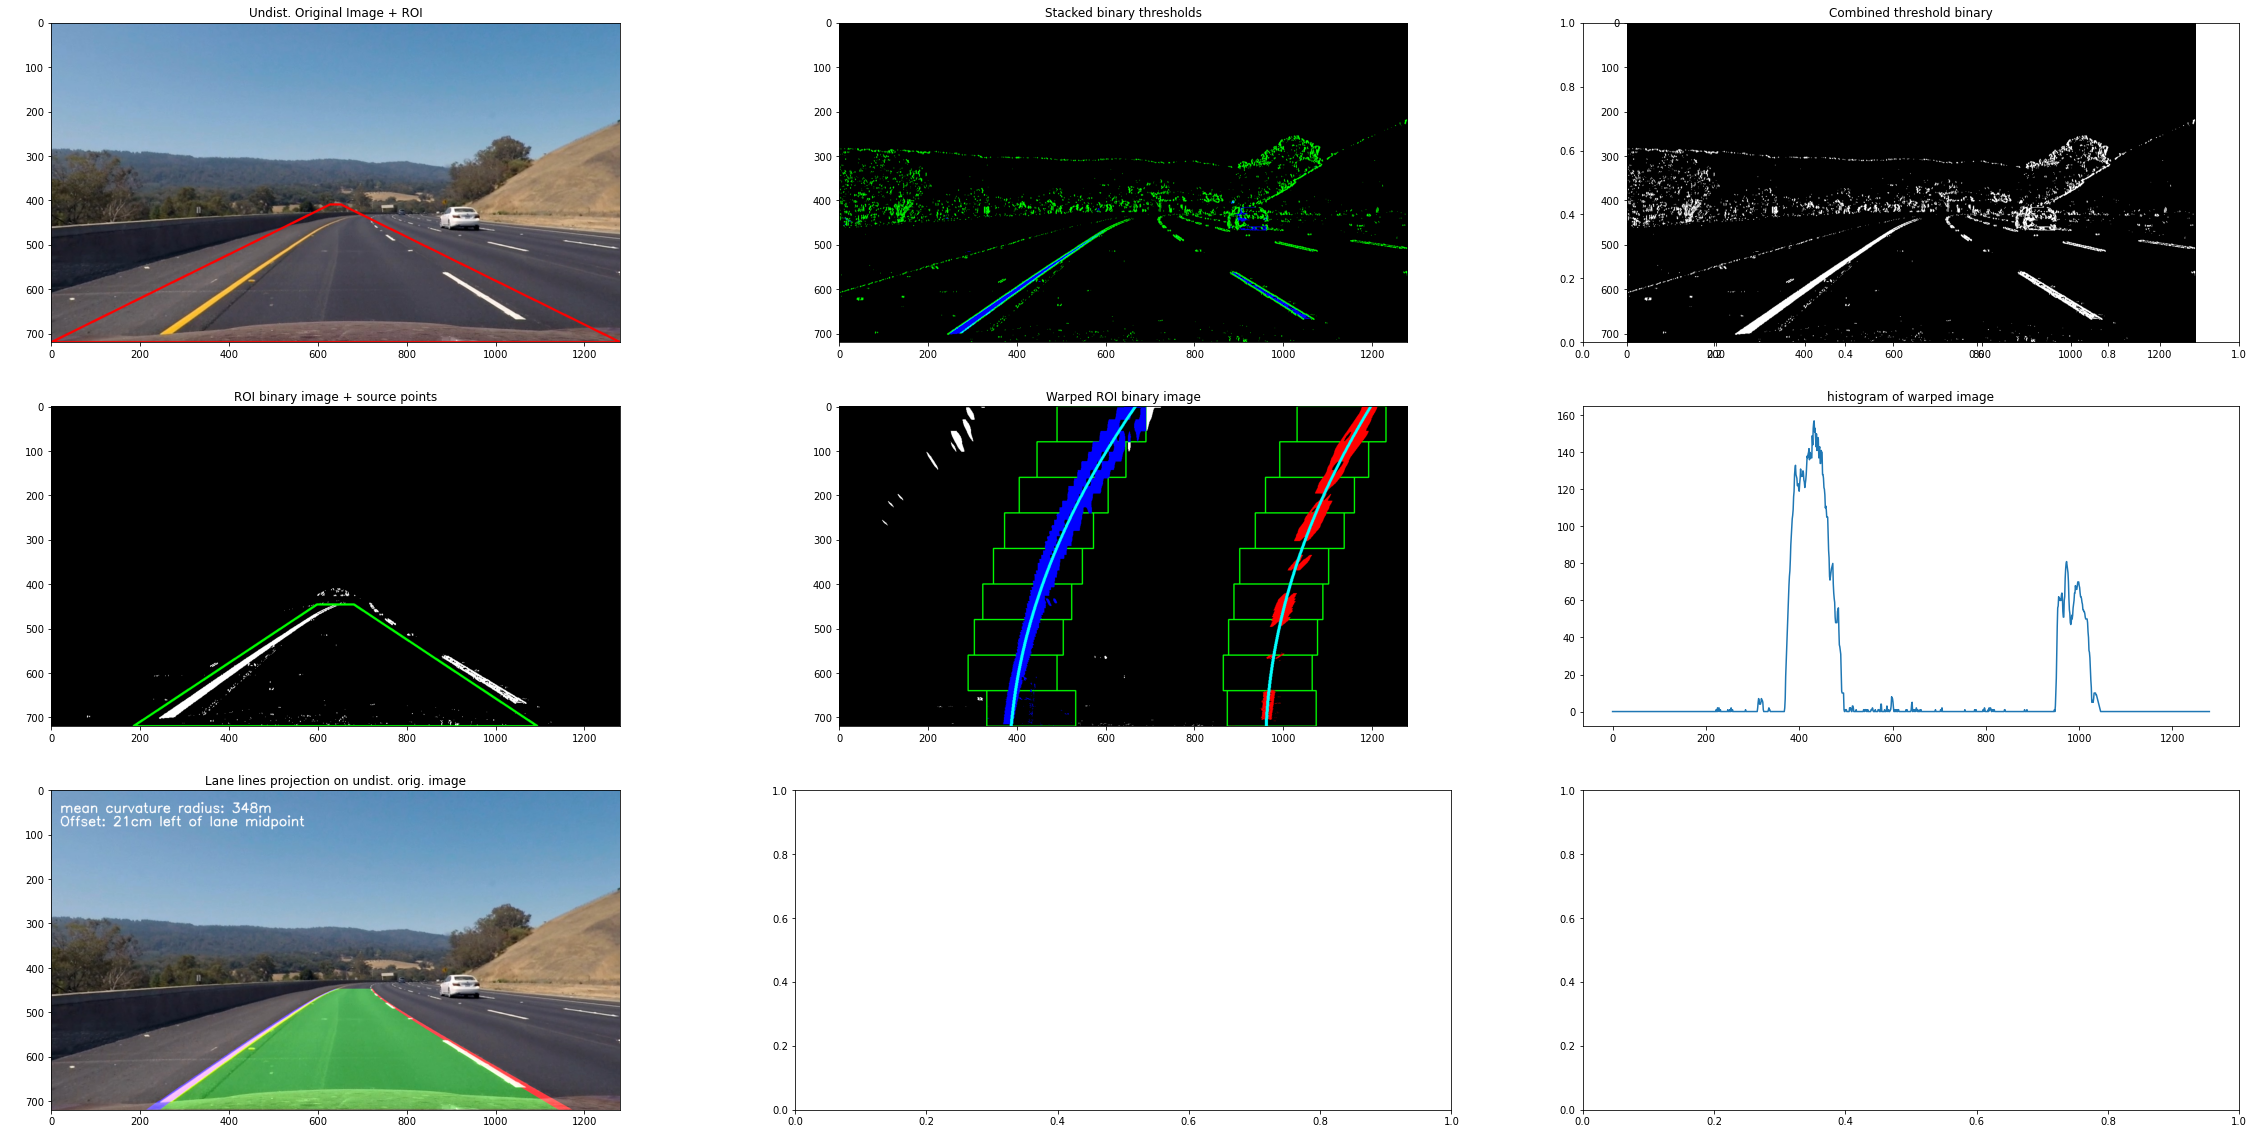

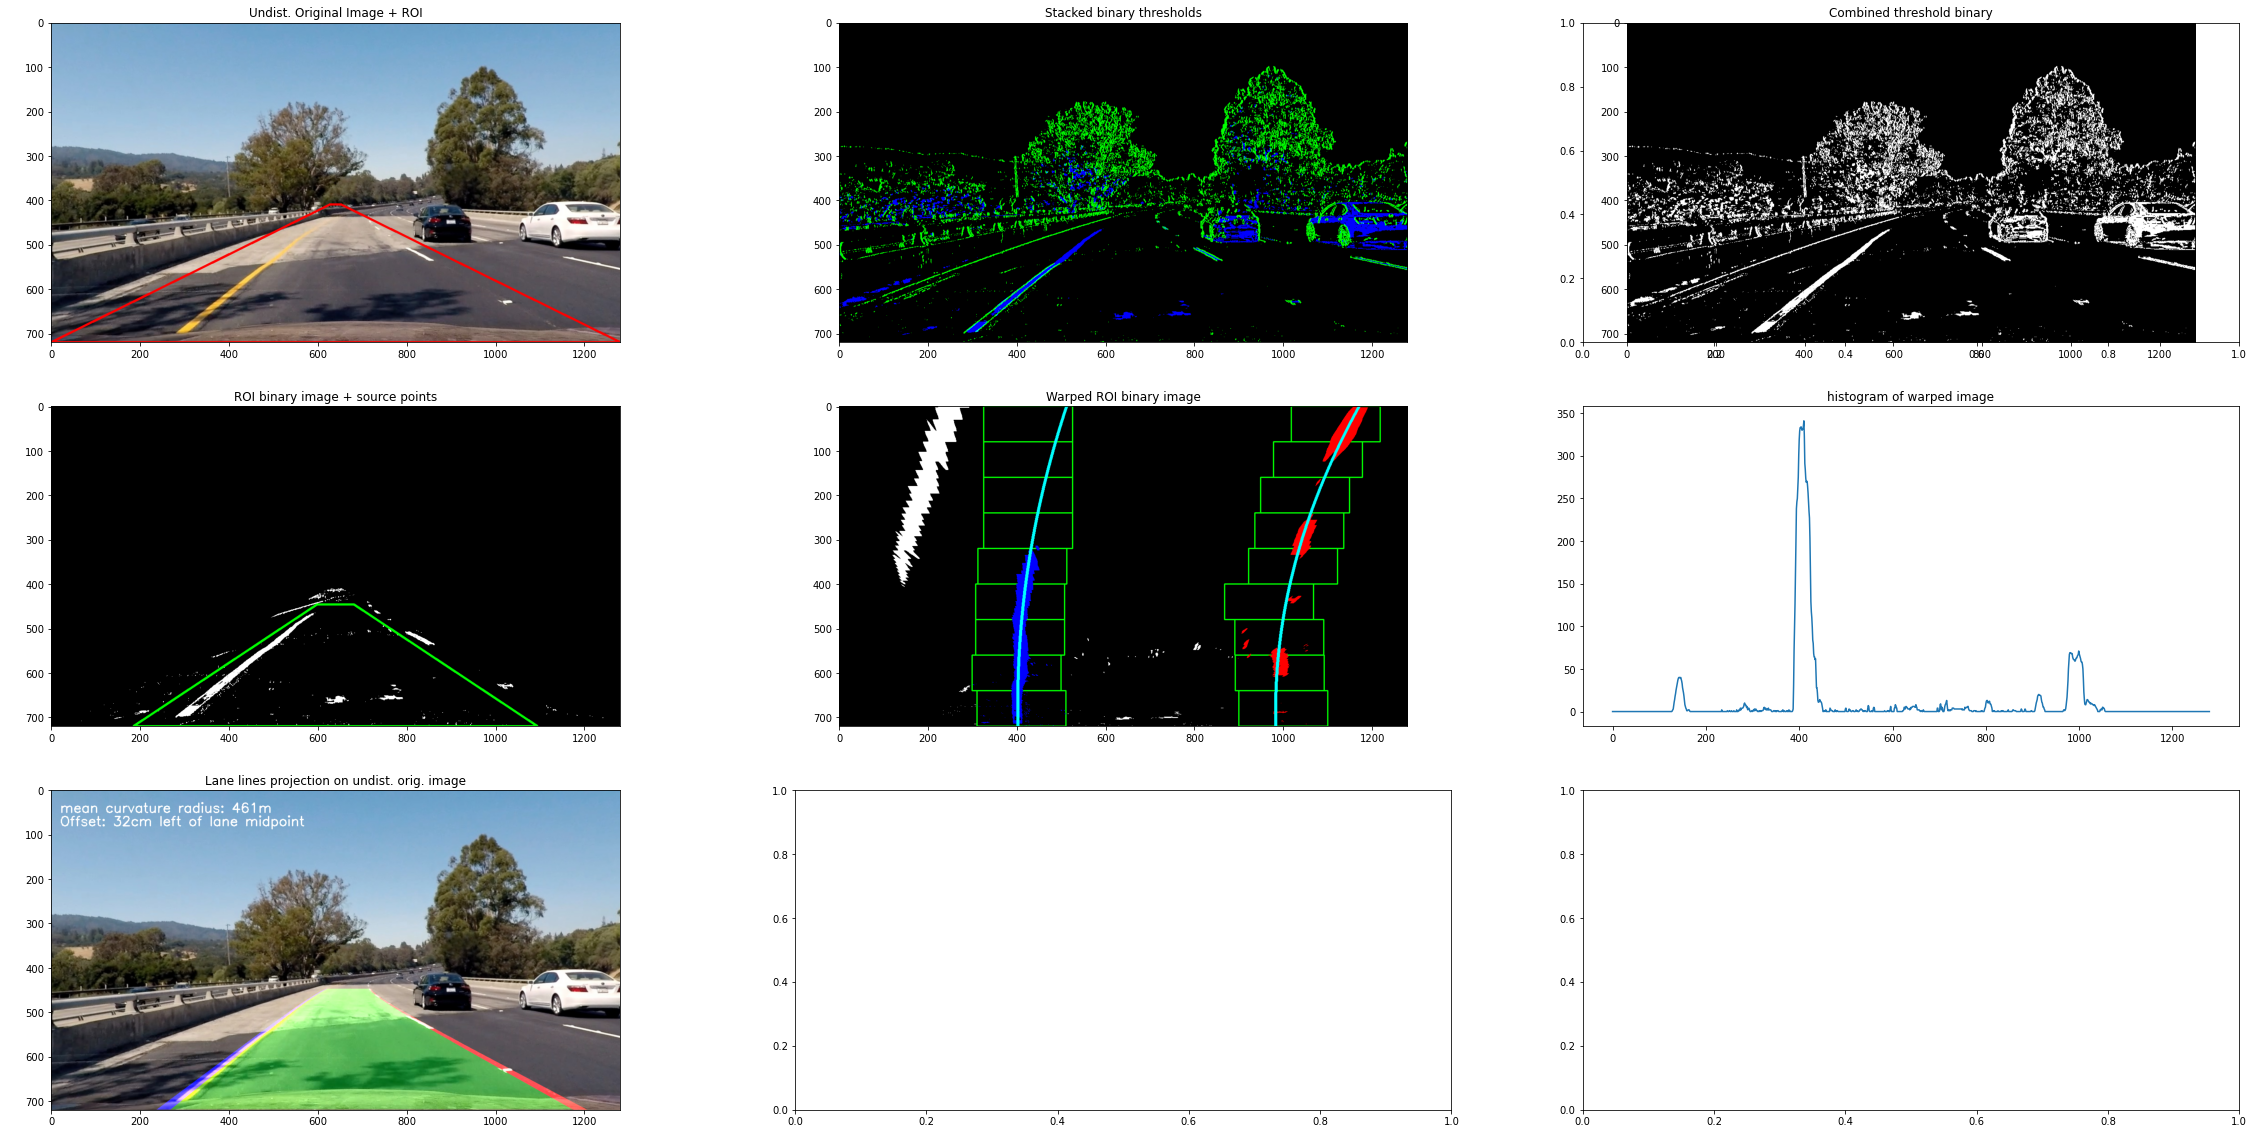

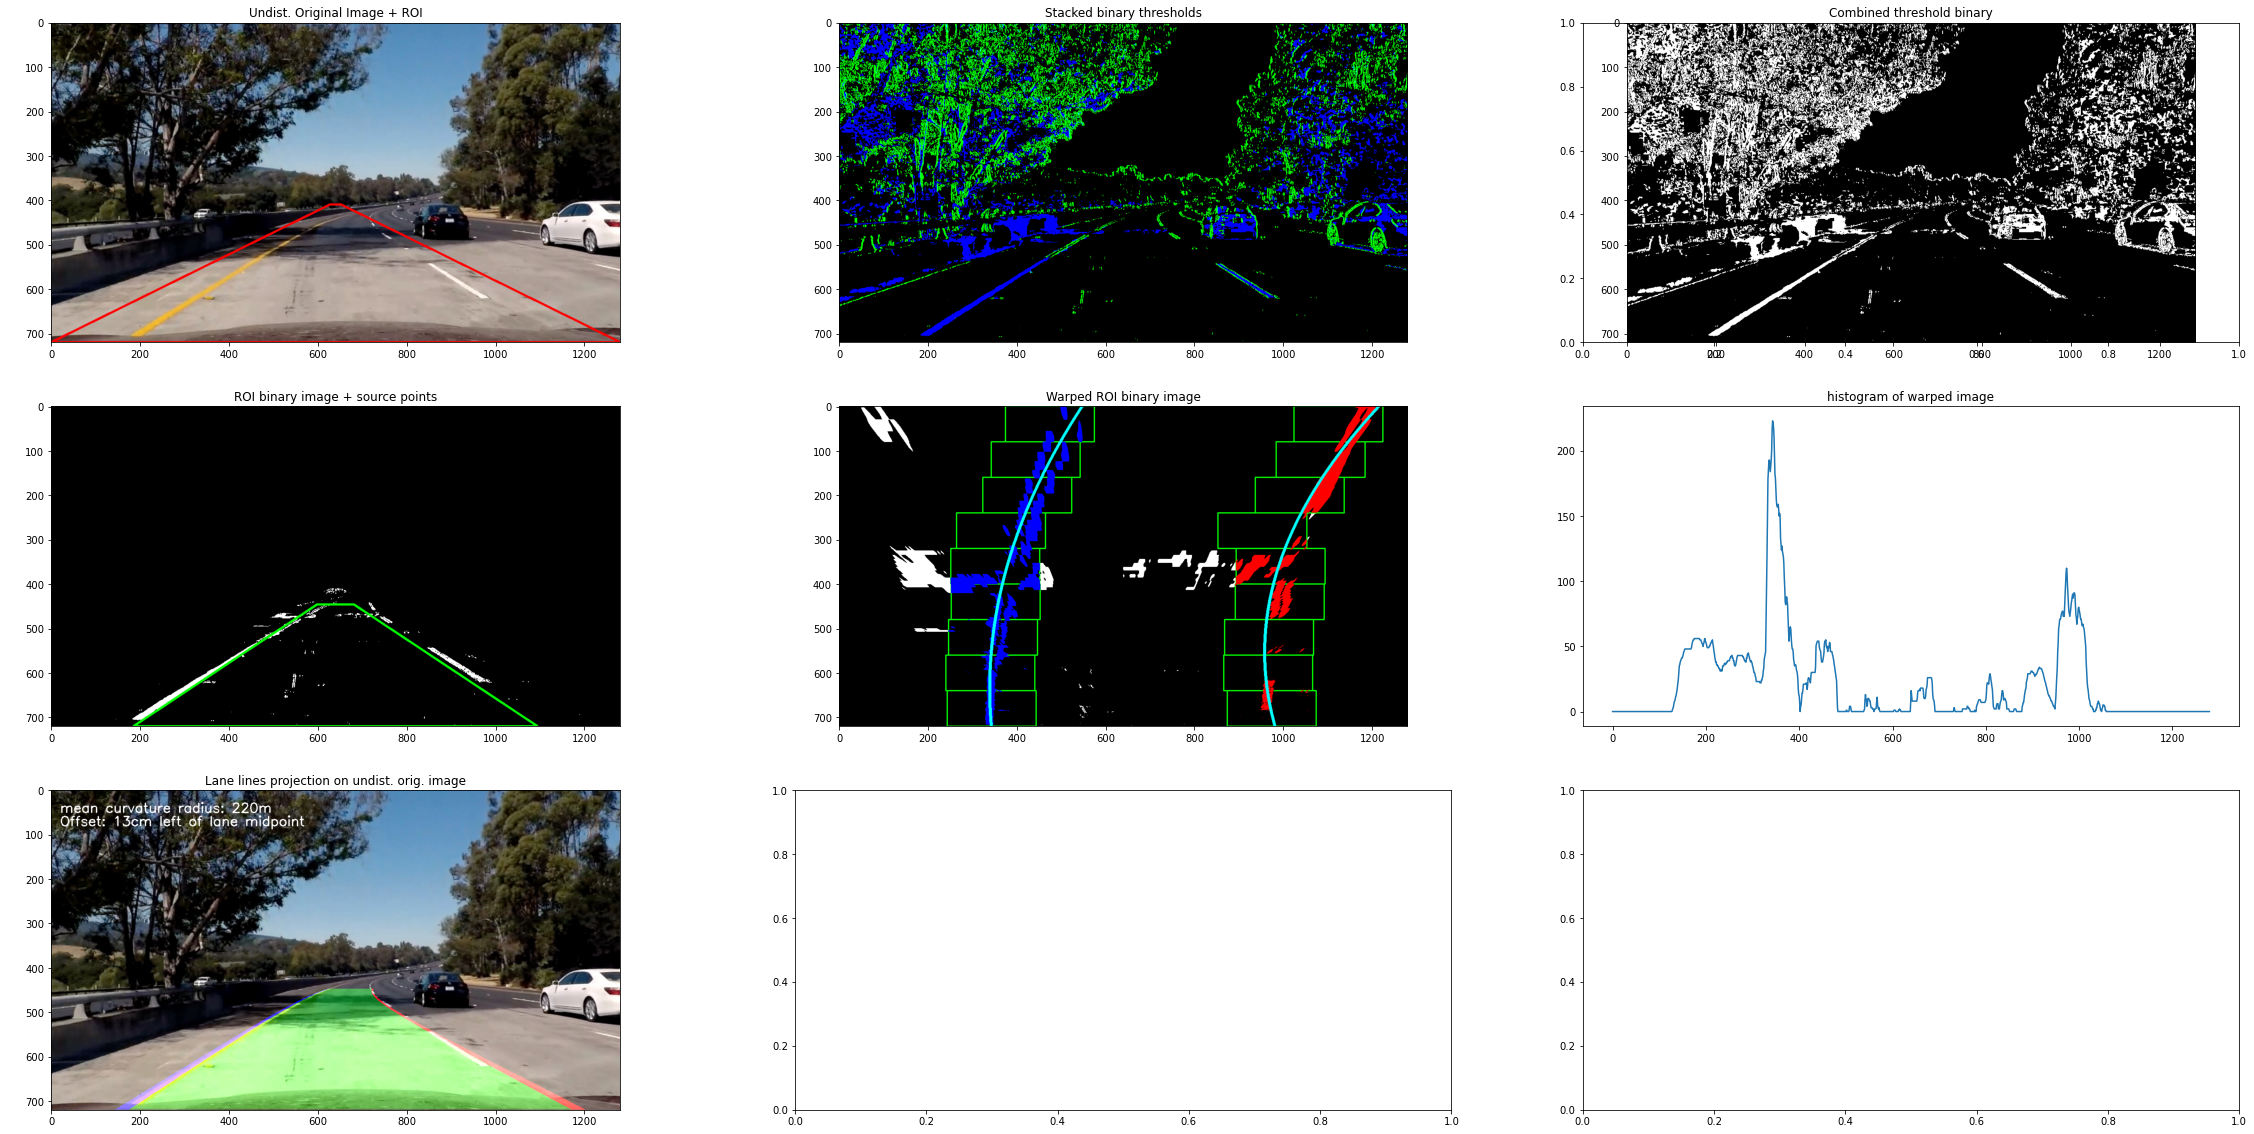

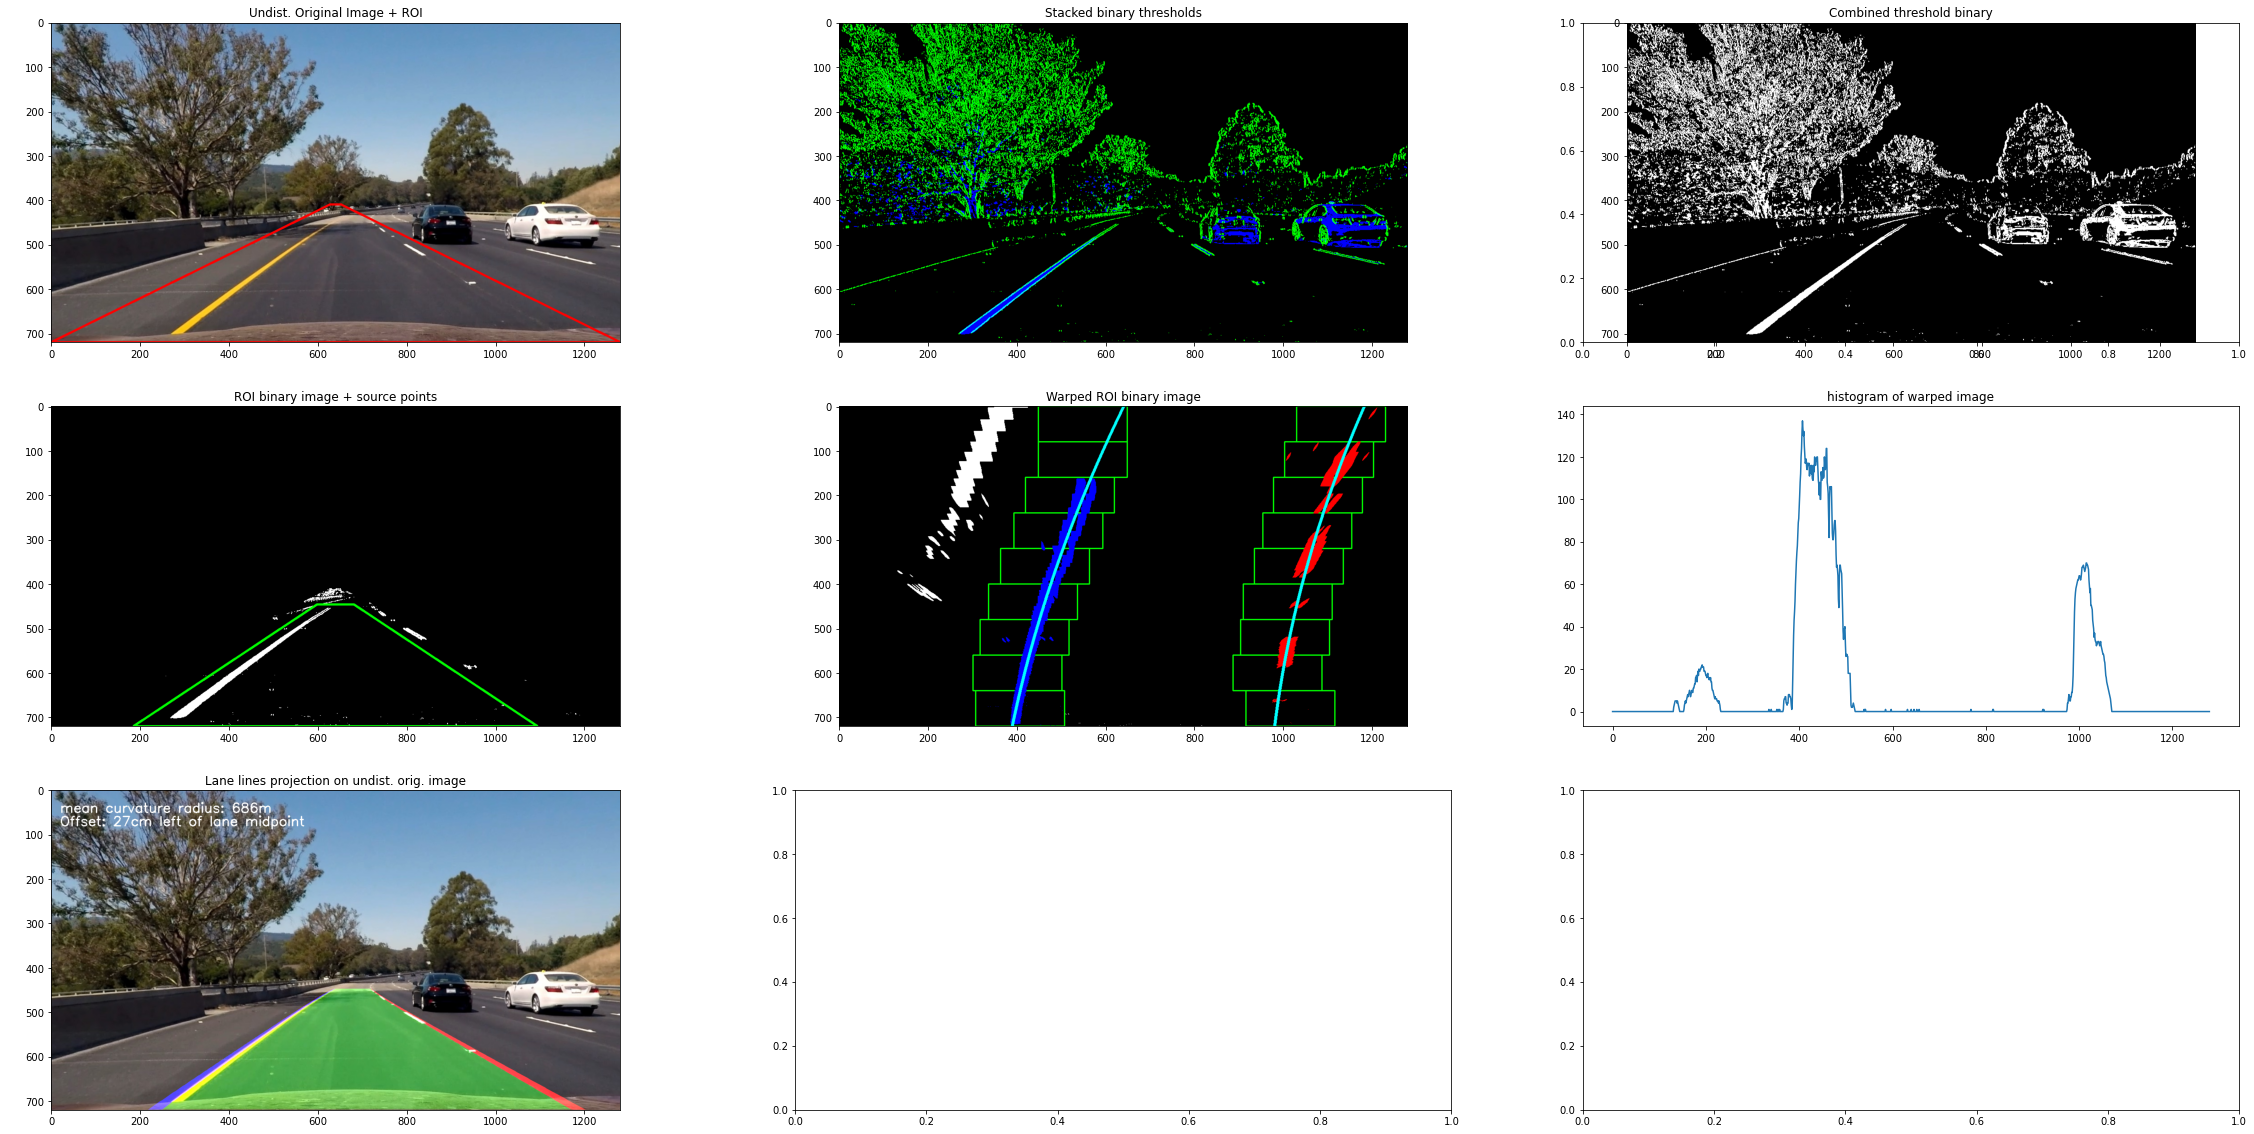

In [11]:
##### CALIBRATE CAMERA #####

# Parameters
plots = True # Do not output any images along pipeline
calibration_plots = False # Do not output any undistorted calibration images

# General folders and parameters
calib_folder = 'camera_cal'
output_folder = 'output_images'

#  Camera calibration parameters
chessboard_rows = 6
chessboard_columns = 9

# Only execute camera calibration if matrix has not been defined yet
try:
    mtx
except NameError:
    mtx, dist = calibrate_camera(chessboard_rows, chessboard_columns, calib_folder, output_folder, calibration_plots)

    
##### PROCESSING IMAGES ####

# Listing all example image files
dir_examples = 'test_images'
dir_output = 'output_images'

# Create Folder if not already existing
pathlib.Path(dir_output).mkdir(parents=True, exist_ok=True)

# List all images in examples folder
imagelist = os.listdir(dir_examples)

for file in imagelist:

    img = mpimg.imread(dir_examples + '/' + file)
    result = lane_detect(img, mtx, dist, plots)
    
    mpimg.imsave(dir_output + '/result_' + file, result, format='jpg')
    
    

---
## Test on videos

### Import libraries

In [12]:
## Test on Videos
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML



### Set processing function incl. parameters

In [13]:
def process_image(image):
    # Setting parameters
    # /rest is maintained from lane detection in image
    plots = False # Do not output any images along pipeline
    
    result = lane_detect(image, mtx, dist, plots)

    return result

### Start video image processing

In [14]:
dir_output = 'output_videos'
file_input = 'project_video.mp4'
clip1 = VideoFileClip(file_input)

processed_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

# Create Folder if not already existing
pathlib.Path(dir_output).mkdir(parents=True, exist_ok=True)
%time processed_clip.write_videofile(dir_output + '/processed_' + file_input, audio=False)

t:   0%|                                                                    | 2/1260 [00:00<01:22, 15.22it/s, now=None]

Moviepy - Building video output_videos/processed_project_video.mp4.
Moviepy - Writing video output_videos/processed_project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/processed_project_video.mp4
Wall time: 2min 10s


### Play video inline

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(dir_output + '/processed_' + file_input))